Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [2]:
series = pd.read_csv("international-airline-passengers.csv")["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]

### Хольт-Винтерс
#### Используем этот метод так как он помогает учесть и сезонность, и тренд

In [3]:
# функция по ряду и по длине сезона возвращает тренд
def initial_trend(series, season_len):
    s=0
    for i in range(len(series)-12):
        s=s+float(series[i + season_len] - series[i]) / season_len    
    return (s / season_len)

In [4]:
# функция по ряду и по длине сезона возвращает сезонные изменения
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [5]:
# функция по ряду и по длине сезона возвращает предсказанные значения
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [6]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [7]:
# функция считает среднее по средней квадратической ошибке для кросс-валидации
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

#### Нестационарный ряд

In [8]:
train, val = series[:65], series[65:]

In [9]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [10]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.1884163086659126
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.99200722e-07, 2.02615702e-07, 3.05311332e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 216
      nit: 42
   status: 0
  success: True
        x: array([0.07483236, 0.32891783, 0.89339398])


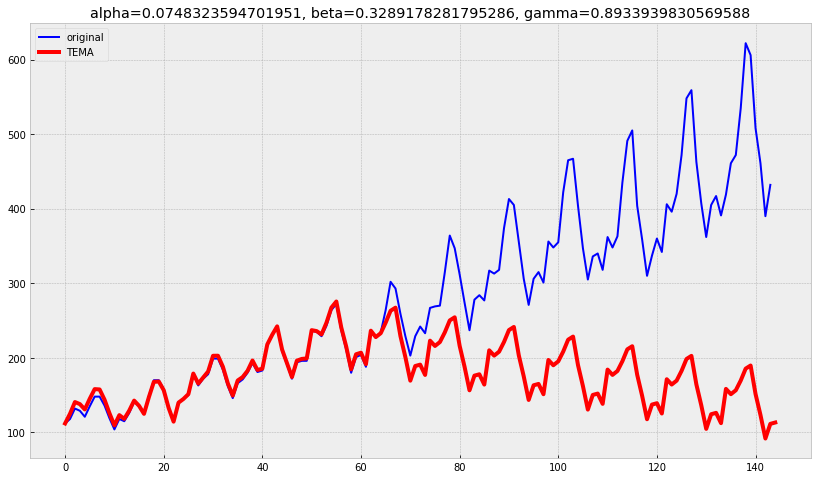

In [11]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [12]:
res=triple_exponential_smoothing(train, 12, 0.07483236, 0.32891783, 0.89339398, len(val))

In [13]:
mean_squared_error(res[65:-1], val[:-1])

44811.25935059126

#### Стационарный ряд

In [14]:
series = boxcox(series, 0)

C:\Users\GreenBenito\anaconda3\lib\site-packages\scipy\stats\morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [15]:
series = series[1:] - series[:-1]

In [16]:
series = series[12:] - series[:-12]

In [17]:
train, val = series[:65], series[65:]

In [18]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [19]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.1884163086659126
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.99200722e-07, 2.02615702e-07, 3.05311332e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 216
      nit: 42
   status: 0
  success: True
        x: array([0.07483236, 0.32891783, 0.89339398])


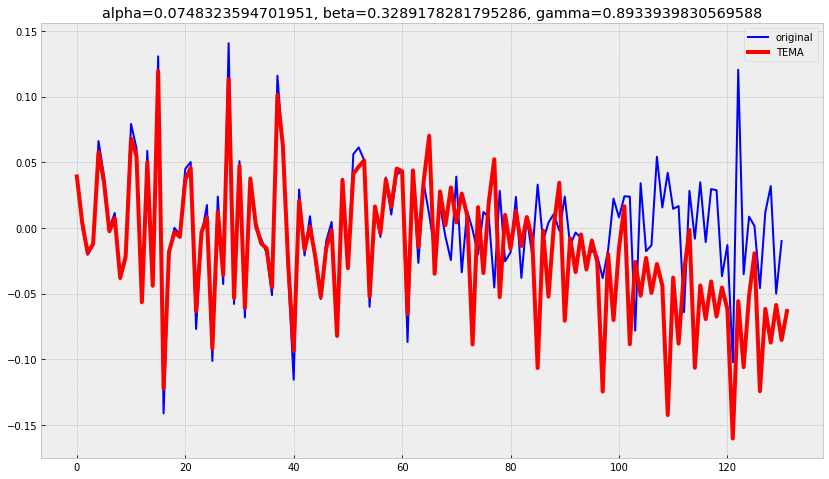

In [20]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [21]:
res=triple_exponential_smoothing(train, 12, 0.07483236, 0.32891783, 0.89339398, len(val))

In [22]:
mean_squared_error(res[65:-1], val[:-1])

0.004352007379275326